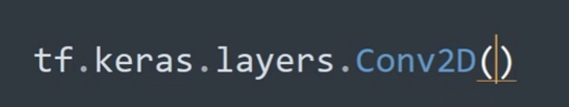

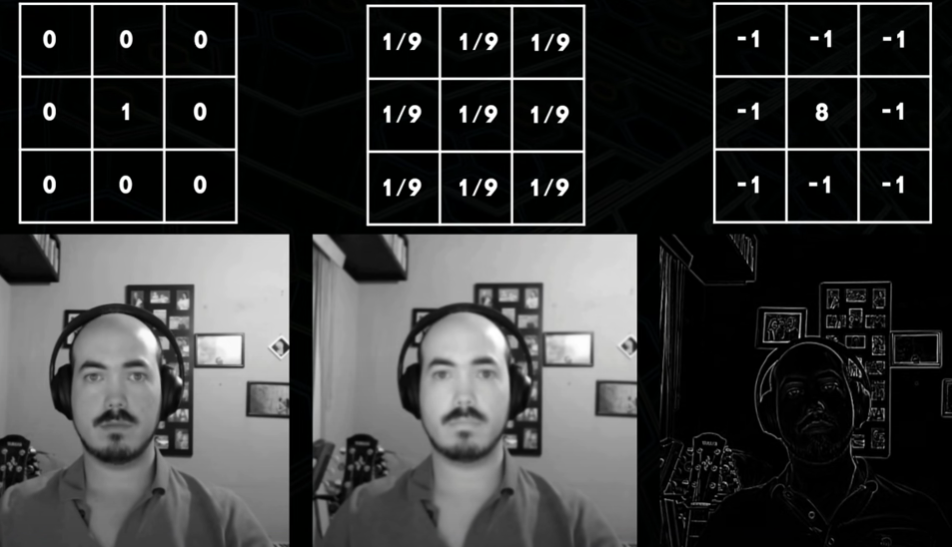

(núcleos, tamaño_núcleos, tamaño_imagen_entrada, canales)
Como en canales vamos a usar blanco y negro, sólo le ponemos 1.
No se ha especificado lcas casillas de los núcleos, que son los que indican qué transformación se hace sobre la imagen.
Esa es la parte interesante de las redes convolucionales, porque, al igual que las redes neuronales regulares adaptan sus pesos de forma automática como manera de entrenamiento para mejorar sus resultados, una capa de convolución ajusta los valores de las casillas de los núcleos de manera automática. Por lo que es posible que uno aprende a detectar patrones, otro a dectectar ejes..etc, eso es asunto de la parte de entrenamiento.

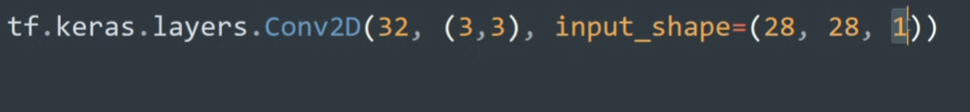

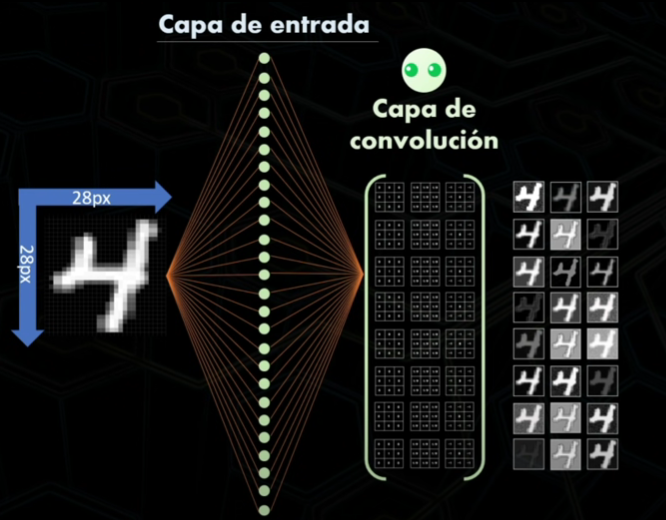

Neurona simple:

Si la imagen fuera a color, la imagen trabaja con 3 canales, rojo, verde, azul. 
Toda imagen se puede separar en sus 3 canales. En este caso, cada uno de los  núcleos estará conformado por 3 matrices diferentes (una para canal):
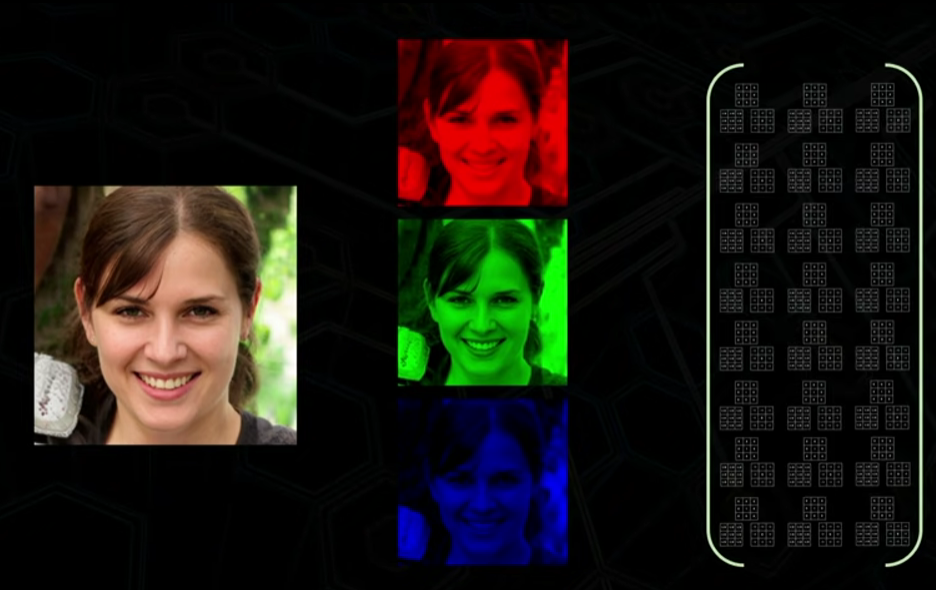


Por ejemplo, el 1º de los 32 núcleos haría este proceso; llega la imagen, separa en los 3 canales, el núcleo utiliza una matriz diferente para cada canal:
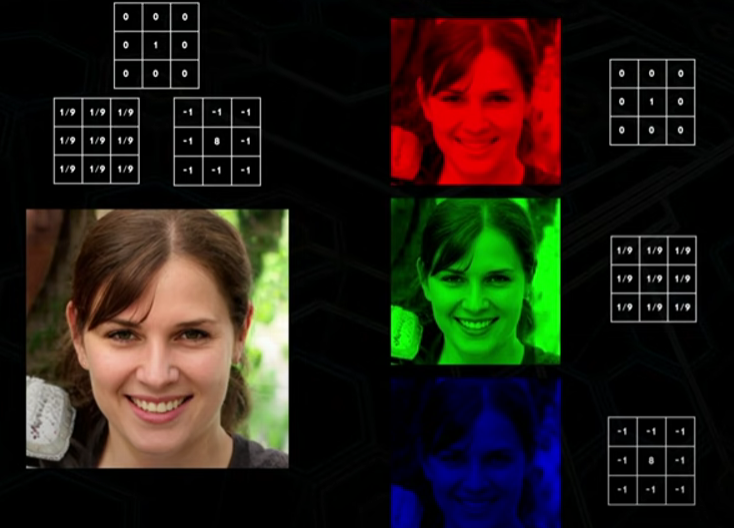

....Y hace las 3convoluciones por separado:
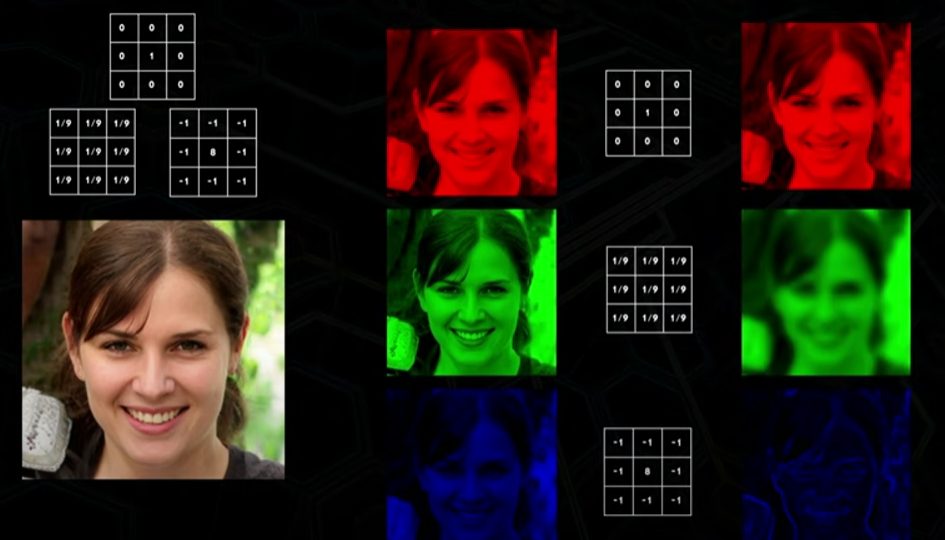

Y al final se va píxel por pixel sumando resultados y agregando un sesgo. Y aunque cada uno de los 32 núcleos hace internamente 3 convoluciones por separado (en total 96 convoluciones), el resultado es sólo una imagen por núcleo (32 imágenes en total):
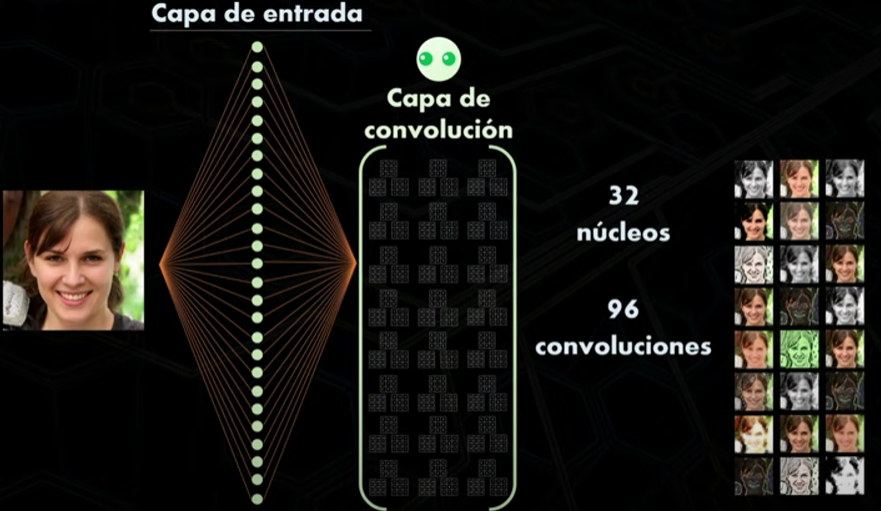

La neurona compleja:

Se usa otro tipo de capa, la cual nos servirá para agrupar la información que nos da la capa de convolución y depender menos de la posición y forma en la imagen. Por tanto, esta capa se llama capa de agrupación, tiene 2 grandes objetivos;
· Reducir el tamaño de la imagen.
· Resaltar las características más importantes.
Hay varias capas de agrupación, pero la más usada es la Agrupación Máxima. Lo que hace es lo siguiente:
Recibe una entrada, la cual ya ha pasado por un proceso de convolución, y definimos una matriz de p.e 2x2 que pasaremos a través de la imagen, empezando por la esquina izq, y de los pixeles que encierra la matriz nos quedamos sólo con el mayor de todos(el resto se descartan) y lo pasamos a una imagen resultante, y proseguimos atravacesando la imagen. En la convolución avanzaba de píxel en píxel, pero en ésta de Agrupación se avanza según el tamaño de la matriz (2x2), ese gap se llama zancada, y es modificable:
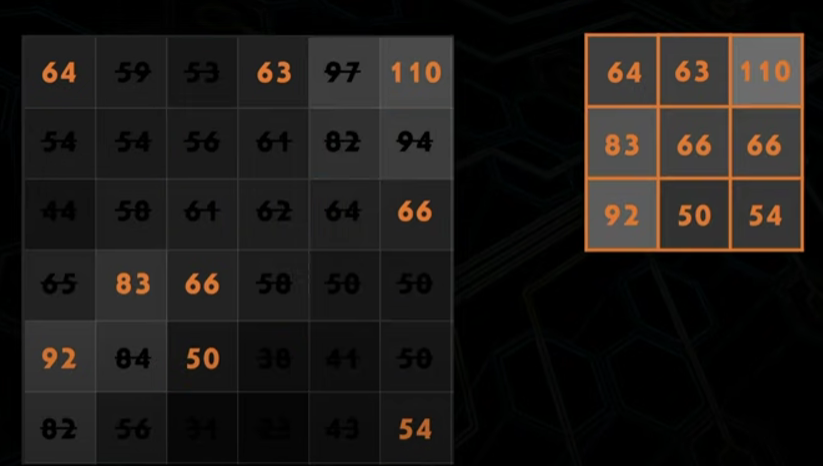

Primero se ve la COnvolución y luego la agrupación máxima
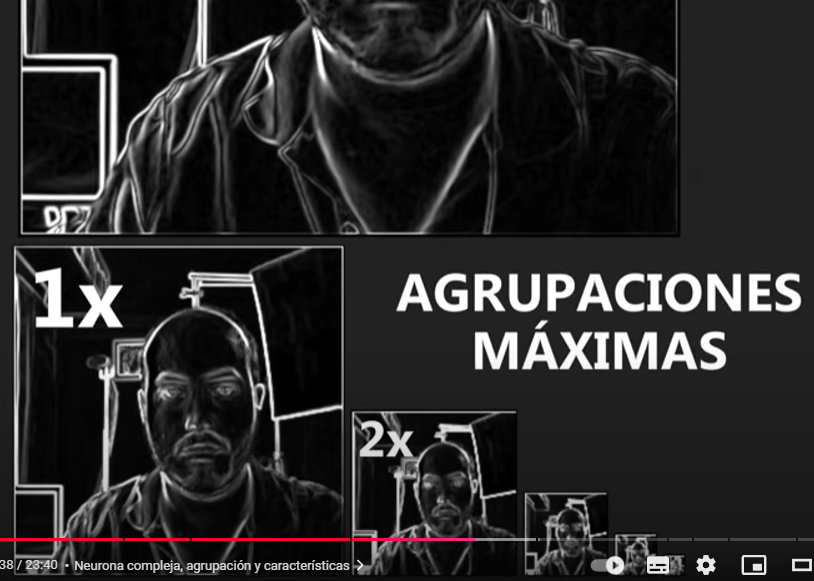

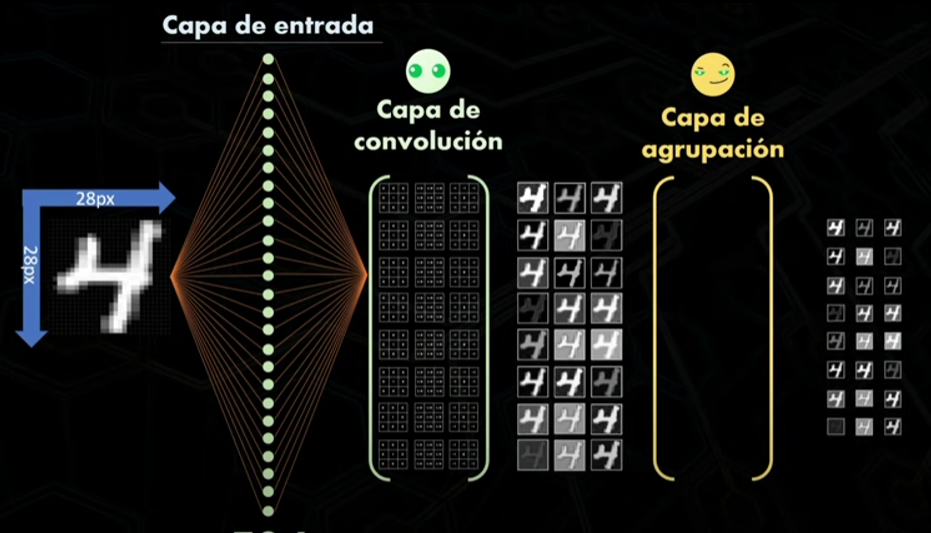


Capa de Convolución, Capa de Agrupación, Capa de Convolución, Capa de Agrupación, Capa de Convolución, Capa de Agrupación.....
Se usan varias capas, una despúes de la otra:
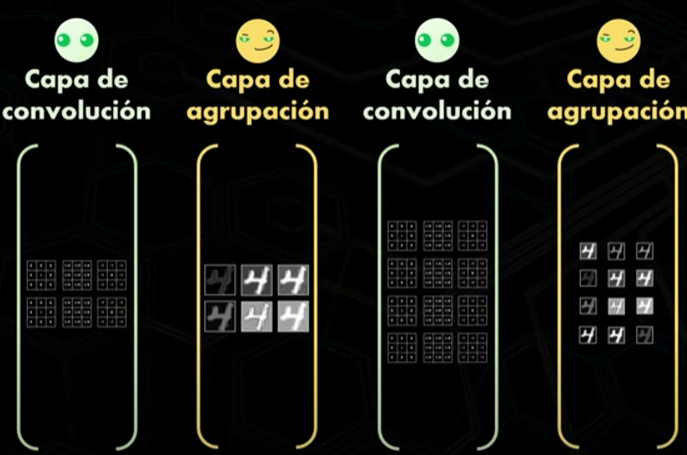

Y entre más avanzamos, más pequeña se va haciendo la imagen por las capas de agrupación:
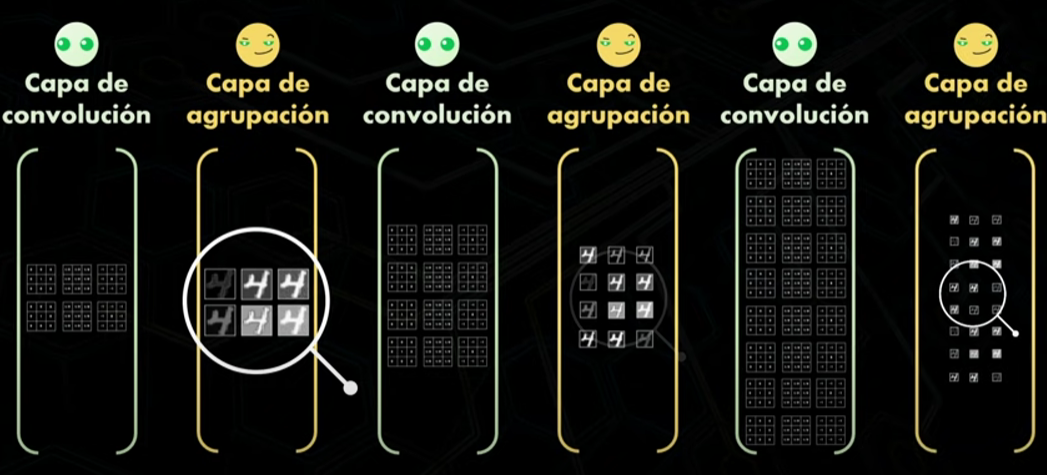

Y por lo tanto podemos agregar más filtros(núcleos) en las capas de convolución.
Otra manera de decirlo es que la sección de convolución (imagen) se vuelve más pequeña, pero más ancha porque tiene más nucleos para convolución.
Esto es que cada serie de capas extrae patrones cada vez más complejos, comenzando por ejes, figuras, formas, objetos.

En el caso de los números, (ejes, figuras simples) las figuras simples serían las CARACTERÍSTICAS que buscamos, p.e líneas y círculos, que podemos dar a las redes regulares para realizar una clasificación:
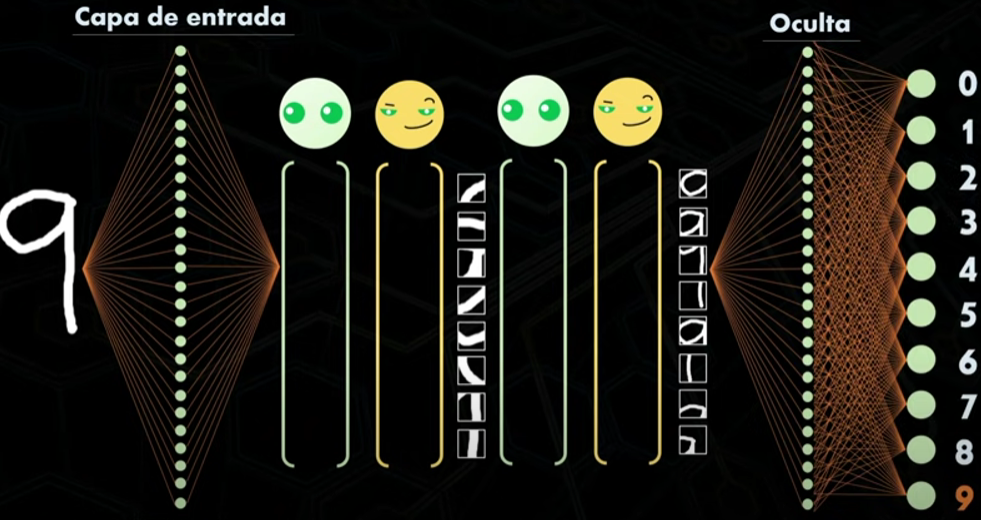

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds 
#
# Si da error meter en terminal
# conda install -c conda-forge ipywidgets
# ó
# pip install ipywidgets

In [ ]:
#Descargar el set de datos
datos, metadatos = tfds.load('mnist', as_supervised=True, with_info=True)

In [7]:
#Obtener el split para train y para pruebas (60k,10k)
entrenamiento, prueba = datos['train'], datos['test']


In [8]:
#Crea la función de normalización. Se quiere que se pase de valores de RANGO 0--255 a 0--1
def normalizar (imag, etiquetas):
    imag=tf.cast(imag, tf.float32)
    imag /= 255 #Como quiere que sea hasta el valor 1, se divide entre 255
    return imag, etiquetas
    

In [9]:
#Procedemos a normalizar los datos de entrenamiento con la función ç
# de normalización
entrenamiento =  entrenamiento.map(normalizar)

prueba = prueba.map(normalizar)


In [ ]:
#Agregar a cache (usar memoria en lugar de disco, entrenamiento mas rapido)
entrenamiento = entrenamiento.cache()
pruebas = prueba.cache()

clases = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [ ]:
#Codigo para mostrar imagenes del set, no es necesario ejecutarlo, solo imprime unos numeros :)
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))

for i, (imagen, etiqueta) in enumerate(datos_entrenamiento.take(25)):
  imagen = imagen.numpy().reshape((28,28))
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(imagen, cmap=plt.cm.binary)
  plt.xlabel(clases[etiqueta])

plt.show()  

In [10]:
# Ahora definimos el modelo, que va a ser Regular, es decir, sin redes 
# convolucionales todavía
modelo = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28,1)), # Capa que recibe (pixeles_base, pixeles_altura, canal = 1 porque es b/n)

    #Creados capas ocultas p.e 2 capas
    tf.keras.layers.Dense(units=50, activation='relu'), #Capa 1(num neuronas)
    tf.keras.layers.Dense(units=50, activation='relu'), #Capa 2(num neuronas)
    
    tf.keras.layers.Dense(10, activation='softmax') #Capa salida (softmax para que de la predicicón)
])




In [18]:
#Compilar el modelo
modelo.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
#¿por qué hay que compilar el modelo?¿
#Para posteriormente hacer el fit

In [12]:
# Antes de realizar el entrenamiento, hay que obtener primero
# algunas cosas que requieren los Hyperparámetros del modelo cuando haces FIT
# y que se tienen que aplicar tanto a los datos de train como de test 
# antes de nutrir al modelo.

# 1)Se necesita saber el número de datos del entrenamiento y de prueba
num_entrenamiento = metadatos.splits["train"].num_examples
num_prueba = metadatos.splits["test"].num_examples


In [14]:
# 2)Se necesita definir un tamaño de lote, necesario para butch, que es "montón"
# que van a requerir los datos, tanto de train como test.

tamano_lote=32

In [15]:
# Con la siguiente línea entremezclamos los datos y le indicamos que sean en montón
#Shuffle y repeat hacen que los datos esten mezclados de manera aleatoria
#para que el entrenamiento no se aprenda las cosas en orden 
entrenamiento = entrenamiento.repeat().\
    shuffle(num_entrenamiento).\
    batch(tamano_lote) 

In [24]:
# ¿Por qué no hace que los datos de prueba se entremezclen?
# Porque en realidad no los necesitas para entrenar, y por ello
# te da igual que se entremezclen
prueba = prueba.batch(tamano_lote)

In [ ]:
#Ahora sí, hacemos el entrenamiento.
#Recuerda que antes de hacer el FIT, se tuvo que compliar el modelo
import math

historial = modelo.fit(
    entrenamiento, #coges los datos de entrenamiento
    epochs=60, #indicamos 60 épocas
    steps_per_epoch=math.ceil(num_entrenamiento/tamano_lote)
)

In [31]:
#Guardarlo para poder verlo en el explorador, donde puedes dibujar
# un número y ver si el modelo lo predice

##Exportar el modelo al explorador! (Mas detalle de esto en en mi video de exportacion: https://youtu.be/JpE4bYyRADI )
modelo.save('red_regular.h5')

#Convertirlo a tensorflow.js  los comandos son
#!pip install tensorflowjs #En Anconda no estaba disponible, por lo que metí el comando en terminal
#!mkdir carpeta_salida 
#!tensorflowjs_converter --input_format keras numeros_regular.h5 carpeta_salida  #Me saltó un error y me indicó que import tensorflow.compat.v1 as tf1
import tensorflow.compat
""" 
import tensorflow.compat.v1 as tf1 """


' \nimport tensorflow.compat.v1 as tf1 '

In [32]:
import tensorflow.compat.v1 as tf1
!tensorflowjs_converter --input_format keras numeros_regular.h5 carpeta_salida

Traceback (most recent call last):
  File "C:\Users\nel_n\anaconda3\envs\myenv10\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\nel_n\anaconda3\envs\myenv10\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "C:\Users\nel_n\anaconda3\envs\myenv10\Scripts\tensorflowjs_converter.exe\__main__.py", line 4, in <module>
  File "C:\Users\nel_n\anaconda3\envs\myenv10\lib\site-packages\tensorflowjs\__init__.py", line 21, in <module>
    from tensorflowjs import converters
  File "C:\Users\nel_n\anaconda3\envs\myenv10\lib\site-packages\tensorflowjs\converters\__init__.py", line 21, in <module>
    from tensorflowjs.converters.converter import convert
  File "C:\Users\nel_n\anaconda3\envs\myenv10\lib\site-packages\tensorflowjs\converters\converter.py", line 29, in <module>
    import tensorflow.compat.v1 as tf1
ModuleNotFoundError: No module named 'tensorflow.compat'


In [27]:
print(tf.__version__)

2.10.0


In [30]:
print(tensorflow.__version__)

2.10.0


In [36]:
import streamlit as st
import numpy as np
import tensorflow as tf
from PIL import Image, ImageDraw

# Cargar el modelo previamente entrenado
modelo = tf.keras.models.load_model('C:/4_F5/017_track_01/num_reg/numeros_regular.h5')

# Función para procesar la imagen del lienzo
def preprocess_image(image):
    image = image.resize((28, 28))  # Redimensionar a 28x28
    image = image.convert('L')  # Convertir a escala de grises
    image = np.array(image) / 255.0  # Normalizar
    image = np.expand_dims(image, axis=-1)  # Añadir canal
    image = np.expand_dims(image, axis=0)  # Añadir dimensión de lote
    return image

# Título de la aplicación
st.title("Reconocimiento de Números")

# Crear un lienzo para dibujar
canvas_size = 280
canvas = st.empty()
image = Image.new("RGB", (canvas_size, canvas_size), (255, 255, 255))
draw = ImageDraw.Draw(image)

# Interfaz para dibujar
st.write("Dibuja un número en el lienzo y haz clic en 'Predecir'")

# Captura de eventos de dibujo
if st.button("Limpiar"):
    image = Image.new("RGB", (canvas_size, canvas_size), (255, 255, 255))
    st.image(image, use_column_width=True)

# Dibujar en el lienzo
if st.checkbox("Dibuja aquí"):
    x1 = st.slider("X1", 0, canvas_size, 0)
    y1 = st.slider("Y1", 0, canvas_size, 0)
    x2 = st.slider("X2", 0, canvas_size, 0)
    y2 = st.slider("Y2", 0, canvas_size, 0)
    
    draw.line([(x1, y1), (x2, y2)], fill="black", width=10)
    st.image(image, use_column_width=True)

# Botón para predecir el número
if st.button("Predecir"):
    processed_image = preprocess_image(image)
    prediction = modelo.predict(processed_image)
    predicted_number = np.argmax(prediction)
    st.write(f"El número dibujado es: {predicted_number}")


ValueError: Unrecognized keyword arguments: ['batch_shape']

In [38]:

# Crear un modelo simple
modelo = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu', input_shape=(32,)),
    tf.keras.layers.Dense(1)
])

# Compilar el modelo
modelo.compile(optimizer='adam', loss='mean_squared_error')

print("Modelo creado y compilado exitosamente.")

Modelo creado y compilado exitosamente.
